In [12]:
import pandas as pd
import os
import numpy as np


import torch
from torch.utils.data import DataLoader

from src.dataset import KEMDyDataset
from transformers import AutoConfig
from module.KoBertEmotionRecognition import KoBERTEmotionRecognition
from module.Wav2VecEmotionRecognition import Wav2VecEmotionRecognition

from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

F1 Score 평균

In [13]:
path = './results/wav/'
results = []

for dir in os.listdir(path):
    for file in os.listdir(path + dir):
        if file.endswith('.txt'):
            with open(path + dir + '/' + file, 'r') as f:
                sent = f.readlines()[-2]
                sent = sent.split(' ')
                results.append(float(sent[3]))

In [14]:
results

[0.7078496205957914,
 0.8107581766158143,
 0.7675161879593586,
 0.6867219631882661,
 0.7605084768296052]

In [15]:
np.mean(results)

0.7466708850377671

Prediction + Confusion Matrix

In [20]:
modal = 'wav'
l_type = 'emotion'
batch_size = 16
device = torch.device('cuda')

results = []

for k in range(1, 6):
    val_data = KEMDyDataset(modal=modal, k=k, kind='val', l_type=l_type)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    model_name_or_path = "kresnik/wav2vec2-large-xlsr-korean"
    config = AutoConfig.from_pretrained(model_name_or_path,
                                        num_labels=7,
                                        label2id = {'neutral': 0, 'happy': 1, 'surprise': 2, 'angry': 3, 'sad': 4, 'disqust': 5, 'fear': 6},
                                        id2label = {0: 'neutral', 1: 'happy', 2: 'surprise', 3: 'angry', 4: 'sad', 5: 'disqust', 6: 'fear'}
                                        )
    model = Wav2VecEmotionRecognition(config).to(device)
    model.load_state_dict(torch.load(f"./results/wav/wav_emotion_k{k}/wav_emotion_k{k}_best.pth"))

    model.eval()


    for ii, (data, mask, target) in enumerate(val_loader):
        data, mask = data.to(device), mask.to(device)
        target = target.to(device)

        output = model(data, mask)

        _, pred = output.data.topk(1, dim=1)
        pred = pred.t().squeeze()

        for batch in range(batch_size):
            try:
                results.append((target[batch].item(), pred[batch].item()))
            except:
                continue
    # for ii, (session, segment, data, mask, target) in enumerate(val_loader):
    #     data, mask = data.to(device), mask.to(device)
    #     target = target.to(device)

    #     output = model(data, mask)

    #     _, pred = output.data.topk(1, dim=1)
    #     pred = pred.t().squeeze()

    #     for batch in range(batch_size):
    #         try:
    #             results.append((session[batch].item(), segment[batch].item(), target[batch].item(), pred[batch].item()))
    #         except:
    #             continue

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


The target sampling rate: 16000
torch.Size([2619, 512]) torch.Size([2619, 512]) torch.Size([2619])


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


The target sampling rate: 16000
torch.Size([2935, 512]) torch.Size([2935, 512]) torch.Size([2935])


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


The target sampling rate: 16000
torch.Size([2288, 512]) torch.Size([2288, 512]) torch.Size([2288])


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


The target sampling rate: 16000
torch.Size([2716, 512]) torch.Size([2716, 512]) torch.Size([2716])


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


The target sampling rate: 16000
torch.Size([2904, 512]) torch.Size([2904, 512]) torch.Size([2904])


In [16]:
# dataframe = pd.DataFrame(results, columns=['session', 'segment', 'target', 'prediction'])
# dataframe = dataframe.sort_values(['session', 'segment']).reset_index(drop=True)
# dataframe

,session,segment,target,prediction
0,1,1,0,0
1,1,2,0,0
2,1,3,0,0
3,1,4,0,0
4,1,5,0,1
...,...,...,...,...
13457,40,494,0,0
13458,40,495,0,0
13459,40,496,0,0
13460,40,497,0,0


In [21]:
dataframe = pd.DataFrame(results, columns=['target', 'prediction'])
dataframe

,target,prediction
0,1,0
1,1,0
2,1,0
3,1,0
4,0,0
...,...,...
13457,0,0
13458,0,0
13459,0,0
13460,0,0


In [22]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(dataframe['target'], dataframe['prediction'])
print(cf_matrix)

[[11120     0     0     0     0     0     0]
 [ 1528     0     0     0     0     0     0]
 [  221     0     0     0     0     0     0]
 [  228     0     0     0     0     0     0]
 [  193     0     0     0     0     0     0]
 [  108     0     0     0     0     0     0]
 [   64     0     0     0     0     0     0]]


In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

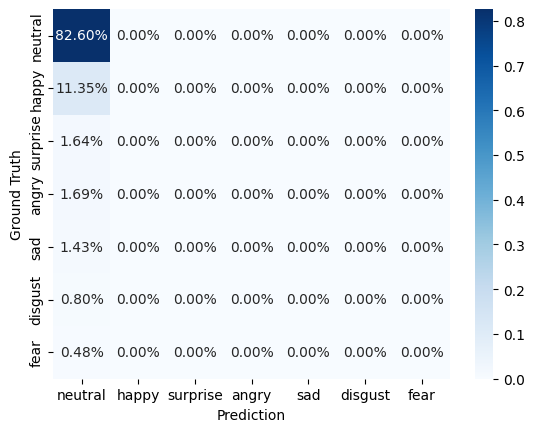

In [28]:
sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True,
            fmt='.2%', cmap='Blues')

plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], ['neutral', 'happy', 'surprise', 'angry', 'sad', 'disgust', 'fear'])
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], ['neutral', 'happy', 'surprise', 'angry', 'sad', 'disgust', 'fear'])

plt.xlabel('Prediction')
plt.ylabel('Ground Truth')

plt.savefig('./figure/confusion_matrix.png')